In [1]:
!nvidia-smi

Tue Feb  8 02:20:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:12:00.0 Off |                    0 |
| N/A   43C    P0    41W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:13:00.0 Off |                    0 |
| N/A   

In [2]:
import os
import gc
import glob
import random
import easydict
from copy import deepcopy
import math
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import openslide
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import wandb
from model import build

2022-02-08 02:20:35.407776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import libtiff
libtiff.libtiff_ctypes.suppress_warnings()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()

print(f'Using {device} device')
if device.type == 'cuda':
    print(f'Your GPU device name: {torch.cuda.get_device_name()}')

Using cuda device
Your GPU device name: NVIDIA A100-PCIE-40GB


In [5]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4'

In [6]:
Image.MAX_IMAGE_PIXELS = None

In [7]:
wandb.init(project='SDP')

wandb: Currently logged in as: changwoomon (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-08 02:20:42.008213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
def seed_everything(random_seed: int):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

In [9]:
##### HYPER PARAMETER

SEED = 42
img_size = (3744, 2496) # width, height
patch_size = (32, 32)
drop_rate = 0.0
EPOCH = 100

In [10]:
seed_everything(SEED)

In [11]:
tvt = pd.read_csv('./220124_tvt_pngpath.csv')

In [12]:
tvt

,Name,Split,full_path,label,png_path
0,A100_00001_02_stm_c0.svs,train,../data2/A100_data/20210824_stomach_c_normal/A...,c0,../data1/A100_data_png/20210824_stomach_c_norm...
1,A100_00003_02_stm_c0.svs,train,../data2/A100_data/20210824_stomach_c_normal/A...,c0,../data1/A100_data_png/20210824_stomach_c_norm...
2,A100_00006_02_stm_c0.svs,train,../data2/A100_data/20210824_stomach_c_normal/A...,c0,../data1/A100_data_png/20210824_stomach_c_norm...
3,A100_00007_02_stm_c0.svs,train,../data2/A100_data/20210824_stomach_c_normal/A...,c0,../data1/A100_data_png/20210824_stomach_c_norm...
4,A100_00009_02_stm_c0.svs,train,../data2/A100_data/20210824_stomach_c_normal/A...,c0,../data1/A100_data_png/20210824_stomach_c_norm...
...,...,...,...,...,...
4889,A100_01266_01_stm_c0.svs,test,../data2/A100_data/20220120_stomach_c_normal/A...,c0,../data1/A100_data_png/20220120_stomach_c_norm...
4890,A100_01266_02_stm_c0.svs,test,../data2/A100_data/20220120_stomach_c_normal/A...,c0,../data1/A100_data_png/20220120_stomach_c_norm...
4891,A100_01266_03_stm_c0.svs,test,../data2/A100_data/20220120_stomach_c_normal/A...,c0,../data1/A100_data_png/20220120_stomach_c_norm...
4892,A100_01266_04_stm_c0.svs,test,../data2/A100_data/20220120_stomach_c_normal/A...,c0,../data1/A100_data_png/20220120_stomach_c_norm...


In [13]:
train_list = tvt.loc[tvt['Split']=='train', 'png_path'].tolist()
valid_list = tvt.loc[tvt['Split']=='valid', 'png_path'].tolist()
test_list = tvt.loc[tvt['Split']=='test', 'png_path'].tolist()

train_label = tvt.loc[tvt['Split']=='train', 'label'].apply(lambda x: x[-1]).astype(int).tolist()
valid_label = tvt.loc[tvt['Split']=='valid', 'label'].apply(lambda x: x[-1]).astype(int).tolist()
test_label = tvt.loc[tvt['Split']=='test', 'label'].apply(lambda x: x[-1]).astype(int).tolist()

In [14]:
tvt.groupby(['Split', 'label']).agg({'Name': 'count'})

Name
Split label      
test  c0      447
      c1      563
train c0     1336
      c1     1976
valid c0      170
      c1      402

In [15]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5],),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
])

In [16]:
## Image level: Laica's image index
DCT_LAICA_CONF = {
    0:0,
    2:1,
    4:2
}

In [17]:
class SlideDataset(Dataset):
    def __init__(self, file_list, label_list, transform=None):
        self.file_list = file_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        try:
            img_path = self.file_list[idx]
            img = Image.open(img_path)

            img_transformed = self.transform(img)
            label = self.label_list[idx]
            return img_transformed, label
    
        except Exception as ex:
            print(idx)
            print(ex)

In [18]:
train_data = SlideDataset(train_list, train_label, transform)
valid_data = SlideDataset(valid_list, valid_label, transform)
test_data = SlideDataset(test_list, test_label, transform)

In [19]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

In [20]:
args = easydict.EasyDict({
    'arch': 'vit',
    'model_name': 'vit_base_patch32_224',
    'pretrained': True,
    'img_height': img_size[0],
    'img_width': img_size[1],
    'patch_height': patch_size[0],
    'patch_width': patch_size[1],
    'drop_rate': drop_rate,
    # 'attn_drop_rate': drop_rate,
    'num_classes': 2,
})

In [21]:
backbone = build.build_module(args).model
backbone
print()

"act_layer":           None
"applied_blocks":      None
"arch":                vit
"args_linattn":        {}
"attn_drop_rate":      0.0
"depth":               12
"distilled":           False
"drop_path_rate":      0.0
"drop_rate":           0.0
"embed_dim":           768
"embed_layer":         <class 'timm.models.layers.patch_embed.PatchEmbed'>
"img_height":          3744
"img_size":            (3744, 2496)
"img_width":           2496
"in_chans":            3
"islinformer":         False
"isperformer":         False
"mlp_ratio":           4.0
"model_name":          vit_base_patch32_224
"norm_layer":          None
"num_classes":         2
"num_heads":           12
"patch_height":        32
"patch_size":          (32, 32)
"patch_width":         32
"pretrained":          True
"qkv_bias":            True
"representation_size": None
"weight_init":         


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Load timm model 'vit_base_patch32_224' | pretrained : True



In [ ]:
class Trainer(nn.Module):
    def __init__(self, _backbone):
        super().__init__()
        
        backbone = deepcopy(_backbone)
        self.divided_model = nn.ModuleList([
            backbone.patch_embed.to(0),
            backbone.pos_drop.to(0),
            backbone.blocks[:3].to(0),
            
            backbone.blocks[3:6].to(1),
            backbone.blocks[6:8].to(2),
            backbone.blocks[8:10].to(3),
            
            backbone.blocks[10:].to(4),
            backbone.norm.to(4),
            backbone.pre_logits.to(4),
            backbone.head.to(4),
        ])
        self.cls_token = backbone.cls_token
        self.dist_token = backbone.dist_token
        self.pos_embed = backbone.pos_embed

    def forward(self, x):
        idx = 0
        for i, m in enumerate(self.divided_model):
            try:
                idx = next(m.parameters()).device.index
            except:
                if i == 8: # LayerNorm 다음 Identity index로 지정해야함
                    # https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#:~:text=self.norm(x)-,if%20self.dist_token%20is%20None%3A,return%20self.pre_logits(x%5B%3A%2C%200%5D),-else%3A
                    x = m(x[:, 0].to(idx))
                else:
                    x = m(x)
                    
                if isinstance(self.divided_model[i], nn.AdaptiveAvgPool2d):
                    x = torch.flatten(x, 1)
                continue
            
            try:
                x = m(x.to(idx))
            except RuntimeError as e:
                if istest:
                    return idx
                    
                print(idx, x.shape, m)
                raise e
            
        return x

In [23]:
model = Trainer(backbone)
model
print()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [25]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.5389	acc: 0.7304
0.7303743961352657
Confusion matrix, without normalization
[[ 840  496]
 [ 397 1579]]


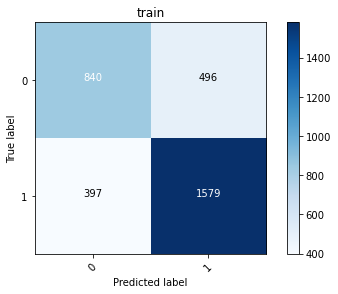

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4365	valid_acc: 0.7727
0.7727272727272727
Confusion matrix, without normalization
[[103  67]
 [ 63 339]]


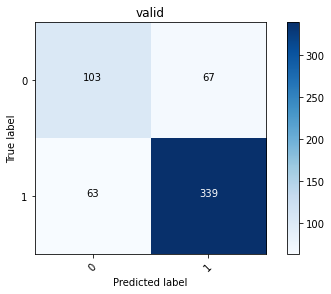


Epoch: 1


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.4556	acc: 0.7811
0.7810990338164251
Confusion matrix, without normalization
[[ 941  395]
 [ 330 1646]]


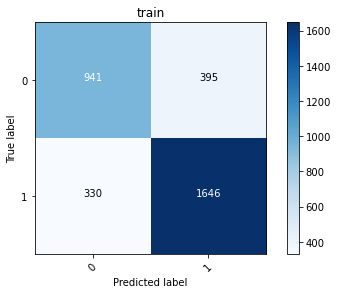

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4819	valid_acc: 0.7675
0.7674825174825175
Confusion matrix, without normalization
[[143  27]
 [106 296]]


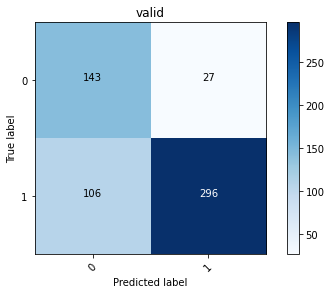


Epoch: 2


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.4066	acc: 0.8020
0.8019323671497585
Confusion matrix, without normalization
[[1011  325]
 [ 331 1645]]


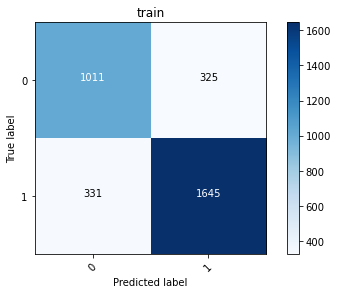

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.5055	valid_acc: 0.7727
0.7727272727272727
Confusion matrix, without normalization
[[155  15]
 [115 287]]


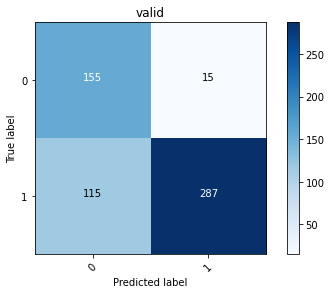


Epoch: 3


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.3719	acc: 0.8312
0.831219806763285
Confusion matrix, without normalization
[[1054  282]
 [ 277 1699]]


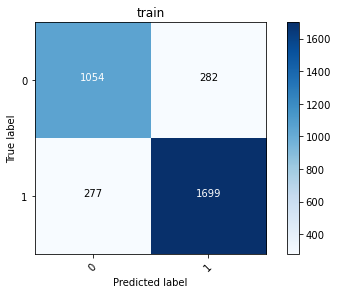

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4373	valid_acc: 0.8042
0.8041958041958042
Confusion matrix, without normalization
[[140  30]
 [ 82 320]]


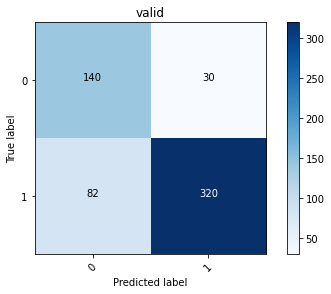


Epoch: 4


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.3375	acc: 0.8491
0.8490338164251208
Confusion matrix, without normalization
[[1094  242]
 [ 258 1718]]


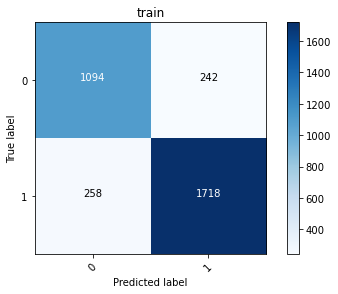

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4085	valid_acc: 0.8164
0.8164335664335665
Confusion matrix, without normalization
[[128  42]
 [ 63 339]]


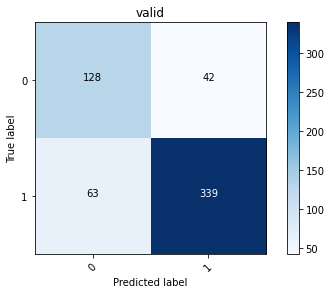


Epoch: 5


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.3031	acc: 0.8657
0.8656400966183575
Confusion matrix, without normalization
[[1123  213]
 [ 232 1744]]


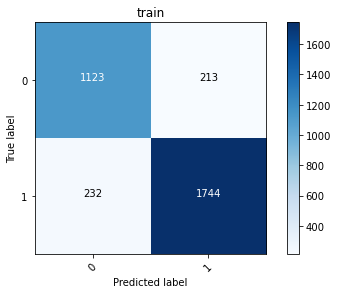

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3608	valid_acc: 0.8409
0.8409090909090909
Confusion matrix, without normalization
[[138  32]
 [ 59 343]]


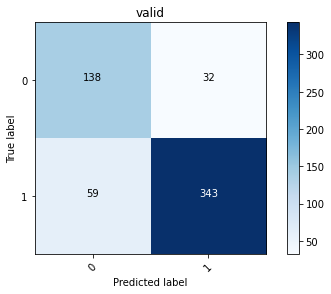


Epoch: 6


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.2791	acc: 0.8759
0.8759057971014492
Confusion matrix, without normalization
[[1149  187]
 [ 224 1752]]


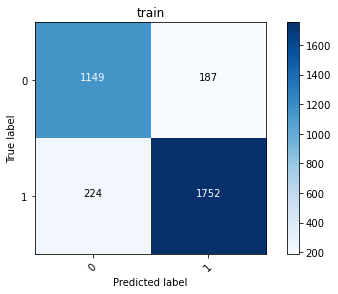

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3652	valid_acc: 0.8357
0.8356643356643356
Confusion matrix, without normalization
[[142  28]
 [ 66 336]]


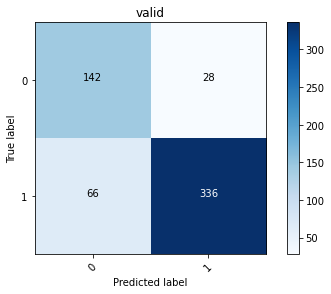


Epoch: 7


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.2504	acc: 0.8937
0.893719806763285
Confusion matrix, without normalization
[[1169  167]
 [ 185 1791]]


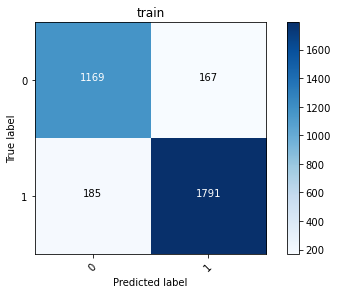

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3605	valid_acc: 0.8427
0.8426573426573427
Confusion matrix, without normalization
[[102  68]
 [ 22 380]]


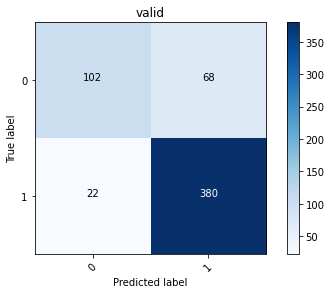


Epoch: 8


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.2296	acc: 0.9004
0.9003623188405797
Confusion matrix, without normalization
[[1191  145]
 [ 185 1791]]


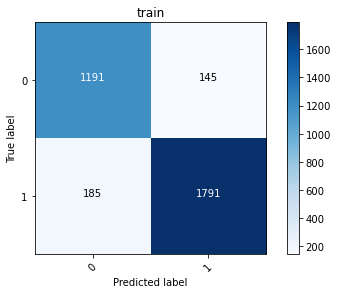

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3631	valid_acc: 0.8462
0.8461538461538461
Confusion matrix, without normalization
[[150  20]
 [ 68 334]]


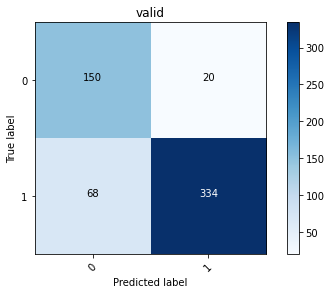


Epoch: 9


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.2061	acc: 0.9191
0.9190821256038647
Confusion matrix, without normalization
[[1226  110]
 [ 158 1818]]


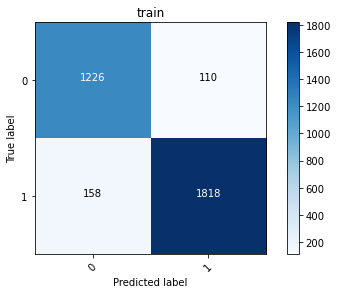

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3439	valid_acc: 0.8549
0.8548951048951049
Confusion matrix, without normalization
[[152  18]
 [ 65 337]]


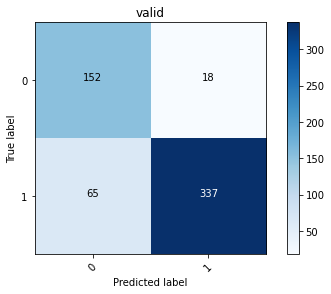


Epoch: 10


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.1849	acc: 0.9255
0.9254227053140096
Confusion matrix, without normalization
[[1228  108]
 [ 139 1837]]


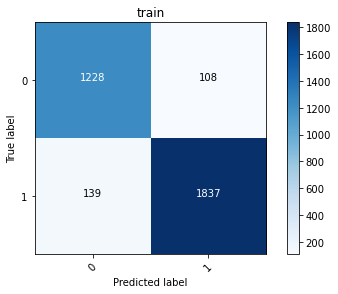

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3183	valid_acc: 0.8601
0.8601398601398601
Confusion matrix, without normalization
[[139  31]
 [ 49 353]]


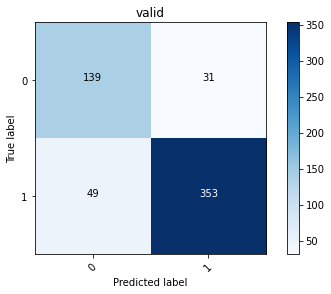


Epoch: 11


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.1745	acc: 0.9285
0.9284420289855072
Confusion matrix, without normalization
[[1242   94]
 [ 143 1833]]


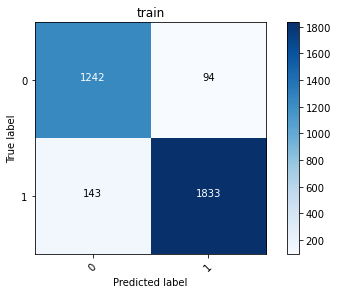

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3944	valid_acc: 0.8217
0.8216783216783217
Confusion matrix, without normalization
[[146  24]
 [ 78 324]]


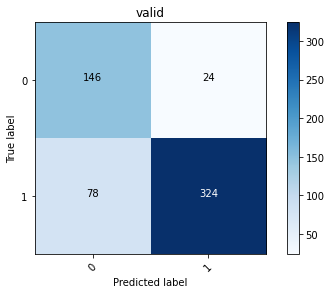


Epoch: 12


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.1500	acc: 0.9439
0.9438405797101449
Confusion matrix, without normalization
[[1261   75]
 [ 111 1865]]


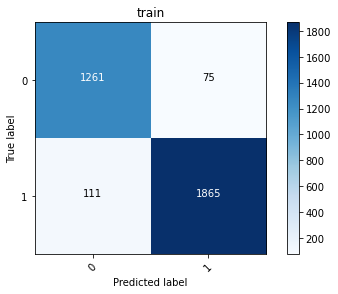

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3684	valid_acc: 0.8427
0.8426573426573427
Confusion matrix, without normalization
[[141  29]
 [ 61 341]]


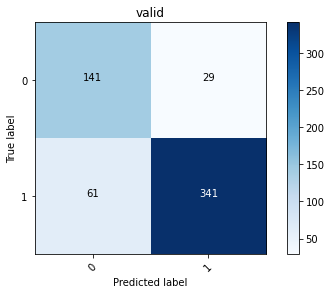


Epoch: 13


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.1435	acc: 0.9430
0.9429347826086957
Confusion matrix, without normalization
[[1265   71]
 [ 118 1858]]


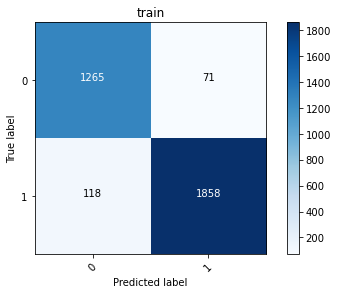

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3779	valid_acc: 0.8357
0.8356643356643356
Confusion matrix, without normalization
[[142  28]
 [ 66 336]]


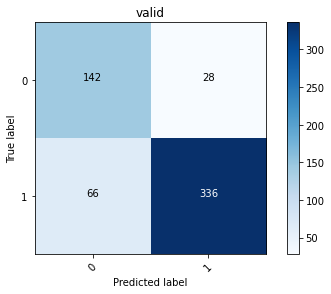


Epoch: 14


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.1281	acc: 0.9505
0.9504830917874396
Confusion matrix, without normalization
[[1259   77]
 [  87 1889]]


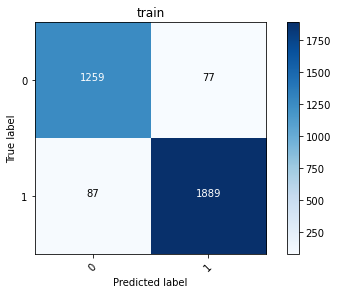

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4578	valid_acc: 0.8339
0.833916083916084
Confusion matrix, without normalization
[[150  20]
 [ 75 327]]


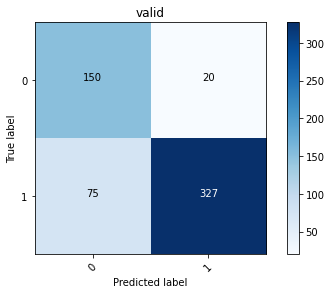


Epoch: 15


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.1156	acc: 0.9572
0.9571256038647343
Confusion matrix, without normalization
[[1284   52]
 [  90 1886]]


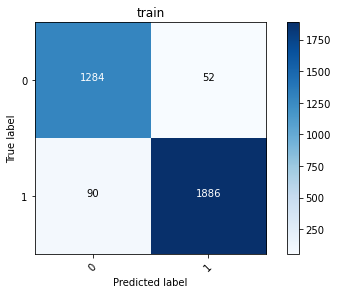

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3671	valid_acc: 0.8392
0.8391608391608392
Confusion matrix, without normalization
[[143  27]
 [ 65 337]]


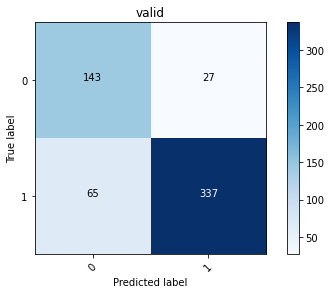


Epoch: 16


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.0980	acc: 0.9656
0.9655797101449275
Confusion matrix, without normalization
[[1293   43]
 [  71 1905]]


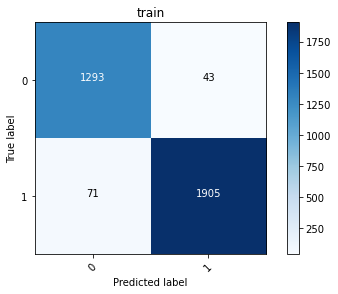

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3943	valid_acc: 0.8532
0.8531468531468531
Confusion matrix, without normalization
[[141  29]
 [ 55 347]]


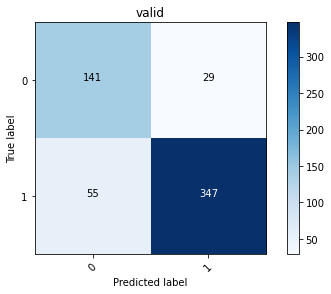


Epoch: 17


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.0875	acc: 0.9674
0.967391304347826
Confusion matrix, without normalization
[[1295   41]
 [  67 1909]]


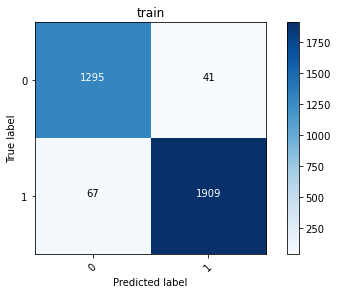

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.3737	valid_acc: 0.8706
0.8706293706293706
Confusion matrix, without normalization
[[136  34]
 [ 40 362]]


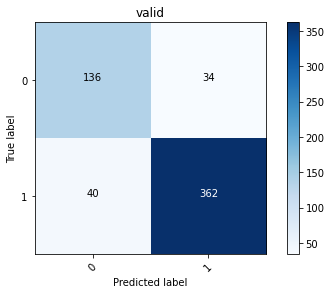


Epoch: 18


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.0798	acc: 0.9710
0.9710144927536232
Confusion matrix, without normalization
[[1300   36]
 [  60 1916]]


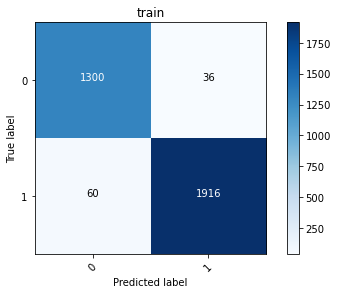

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4301	valid_acc: 0.8532
0.8531468531468531
Confusion matrix, without normalization
[[148  22]
 [ 62 340]]


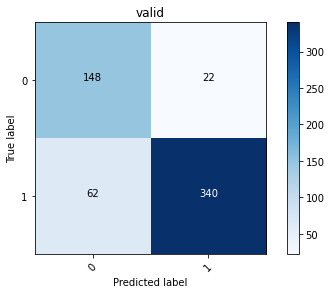


Epoch: 19


  0%|          | 0/3312 [00:00<?, ?it/s]

loss: 0.0739	acc: 0.9729
0.9728260869565217
Confusion matrix, without normalization
[[1300   36]
 [  54 1922]]


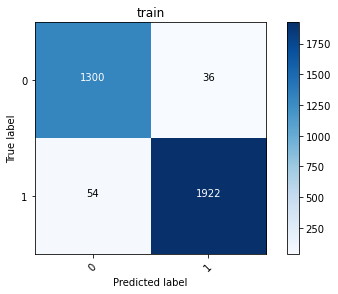

  0%|          | 0/572 [00:00<?, ?it/s]

valid_loss: 0.4278	valid_acc: 0.8601
0.8601398601398601
Confusion matrix, without normalization
[[140  30]
 [ 50 352]]


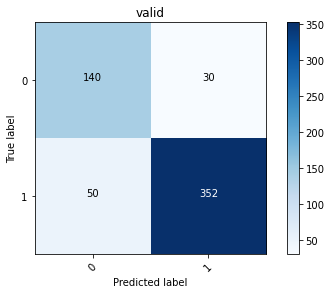


Epoch: 20


  0%|          | 0/3312 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
wandb.watch(model)
seed_everything(SEED)

for epoch in tqdm(range(EPOCH)):
    print(f'Epoch: {epoch}')
    
    epoch_loss = 0
    epoch_accuracy = 0
    train_label = []
    train_pred = []

    model.train()
    for data, label in tqdm(train_dataloader):
        data = data.to(0)
        label = label.to(0)
        
        optimizer.zero_grad()
        
        output = model(data).to(0)
        
        train_label.extend(label.detach().cpu().numpy())
        train_pred.extend(output.argmax(axis=1).detach().cpu().numpy())
        
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()

        acc = (output.argmax(axis=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)
        
    # scheduler.step()
    
    print(f'loss: {epoch_loss:.4f}\tacc: {epoch_accuracy:.4f}')
    print(accuracy_score(train_label, train_pred))
    plot_confusion_matrix(confusion_matrix(train_label, train_pred), classes=['0', '1'], title='train')
    plt.show()
    
    # model save
    torch.save([model.state_dict(), model.pos_embed], f'epoch_{epoch}.pt')
        
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        valid_label = []
        valid_pred = []
        for data, label in tqdm(valid_dataloader):
            data = data.to(0)
            label = label.to(0)

            val_output = model(data).to(0)
            
            valid_label.extend(label.detach().cpu().numpy())
            valid_pred.extend(val_output.argmax(axis=1).detach().cpu().numpy())
            
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(axis=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_dataloader)
            epoch_val_loss += val_loss / len(valid_dataloader)
    
    print(f'valid_loss: {epoch_val_loss:.4f}\tvalid_acc: {epoch_val_accuracy:.4f}')
    plot_confusion_matrix(confusion_matrix(valid_label, valid_pred), classes=['0', '1'], title='valid')
    plt.show()
    
    wandb.log({
        'epoch': epoch,
        'loss': epoch_loss,
        'acc': epoch_accuracy,
        'valid_loss': epoch_val_loss,
        'valid_acc': epoch_val_accuracy,
    })
    
    print()